# 115.Boston House Price Regression

### 13 개의 독립변수와 1 개의 종속변수 (주택가격 중앙값) 으로 구성

#### 독립변수 (13 개)
CRIM 자치시(town) 별 1인당 범죄율  
ZN 25,000 평방피트를 초과하는 거주지역의 비율  
INDUS 비소매상업지역이 점유하고 있는 토지의 비율  
CHAS 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)  
NOX 10ppm 당 농축 일산화질소  
RM 주택 1가구당 평균 방의 개수  
AGE 1940년 이전에 건축된 소유주택의 비율  
DIS 5개의 보스턴 직업센터까지의 접근성 지수  
RAD 방사형 도로까지의 접근성 지수  
TAX 10,000 달러 당 재산세율  
PTRATIO 자치시(town)별 학생/교사 비율  
B 1000(Bk-0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함  
LSTAT 모집단의 하위계층의 비율(%)   

#### 종속변수 (1 개)
MEDV 본인 소유의 주택가격(중앙값) (단위: $1,000)  

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(100)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Data Load

In [ ]:
# "boston_house.csv" 파일을 읽어와 데이터프레임으로 저장
# 첫 번째 열(index_col=0)을 인덱스로 사용
df_boston = pd.read_csv("boston_house.csv", index_col=0)

# 'MEDV' 열을 제거하여 입력 데이터(boston) 생성
boston = df_boston.drop('MEDV', axis=1)

# 'MEDV' 열을 분리하여 목표 변수(target)로 저장
target = df_boston.pop('MEDV')

Input / Target 지정

In [ ]:
# boston 데이터프레임의 값을 넘파이 배열로 변환하여 X에 저장 (입력 데이터)
X = boston.values

# target 데이터프레임의 값을 넘파이 배열로 변환하여 y에 저장 (목표 변수)
y = target.values

# X와 y의 형태(차원)를 출력하여 데이터 크기 확인
X.shape, y.shape

((506, 13), (506,))

Train/Test split

In [ ]:
# 데이터를 학습용(train)과 테스트용(test)으로 분할
# test_size=0.2 : 데이터의 20%를 테스트 세트로 사용
# random_state=0 : 실행할 때마다 동일한 데이터 분할을 보장하기 위한 랜덤 시드 설정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 분할된 데이터셋의 크기(shape)를 출력하여 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404,) (102,)


Feature Scaling

In [ ]:
# MinMaxScaler 객체 생성 (각 특성을 최소 0, 최대 1 범위로 스케일링)
sc = MinMaxScaler()

# 학습 데이터(X_train)에 대해 스케일링을 학습(fit)하고 변환(transform) 적용
X_train = sc.fit_transform(X_train)

# 테스트 데이터(X_test)에 대해 동일한 변환(transform) 적용 (fit을 다시 하지 않음)
X_test = sc.transform(X_test)

Numpy Data를 torch tensor 로 변환

In [ ]:
import torch  # PyTorch 라이브러리 임포트

# X_train과 X_test 데이터를 PyTorch의 tensor 형태로 변환 (데이터 타입: float32)
X_train_ts = torch.tensor(X_train, dtype=torch.float32)
X_test_ts = torch.tensor(X_test, dtype=torch.float32)

# y_train과 y_test 데이터를 tensor로 변환하고, 2D 형태로 조정 (열 벡터로 변환)
y_train_ts = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_ts = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 변환된 텐서들의 크기(shape) 출력
X_train_ts.size(), X_test_ts.size(), y_train_ts.size(), y_test_ts.size()

(torch.Size([404, 13]),
 torch.Size([102, 13]),
 torch.Size([404, 1]),
 torch.Size([102, 1]))

### Linear Model build
- hidden layer가 한개인 linear regression model

In [ ]:
# 다층 퍼셉트론(MLP) 기반 선형 회귀 모델 정의
class LinearReg(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)  # 첫 번째 완전연결층 (input → 64개 뉴런)
        self.fc2 = nn.Linear(64, 32)         # 두 번째 완전연결층 (64 → 32개 뉴런)
        self.fc3 = nn.Linear(32, output_size)  # 세 번째 완전연결층 (32 → output 크기)
        self.relu = nn.ReLU()                   # 활성화 함수로 ReLU 사용

    def forward(self, x):
        x = self.relu(self.fc1(x))      # 첫 번째 층을 통과한 후 ReLU 활성화 적용
        x = self.relu(self.fc2(x))      # 두 번째 층을 통과한 후 ReLU 활성화 적용
        output = self.fc3(x)            # 최종 출력층 (활성화 함수 없음, 회귀 문제이므로)
        return output                      # 모델의 예측값 반환

model instance 생성

In [ ]:
# 입력 특성 개수(X_train의 열 개수)와 출력 크기(1)를 사용하여 모델 생성
model = LinearReg(X_train.shape[1], 1).to(device)

# 모델 구조 출력
model

LinearReg(
  (fc1): Linear(in_features=13, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

손실함수/optimizer 정의

In [ ]:
# 손실 함수 설정 (MSELoss: 평균 제곱 오차 손실 함수)
criterion = nn.MSELoss()

# 최적화 알고리즘 설정 (Adam 옵티마이저, 학습률 lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Dataset Loader 생성

- torch.utils.data.TensorDataset : Dataset wrapping tensors

In [ ]:
# TensorDataset 생성 (X_train_ts: 입력 데이터, y_train_ts: 정답 레이블)
train_ds = torch.utils.data.TensorDataset(X_train_ts, y_train_ts)

# DataLoader 생성
# - batch_size=32 : 한 번에 32개 샘플씩 미니배치를 구성
# - shuffle=True : 데이터 순서를 섞어서 학습 성능 향상
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

## The training process
- Batch data Load
- model 을 이용하여 batch data 예측  
- loss value 계산
- optimizer 에 저장된 grad value clear
- loss value backpropagate
- optimizer update  

In [ ]:
# 손실 값을 저장할 리스트 초기화
Loss = []
# 학습 반복 횟수 설정
num_epochs = 100

# 학습 루프 시작
for epoch in range(num_epochs):

    for x, y in train_loader:      # 미니배치 단위로 데이터 로드
        x, y = x.to(device), y.to(device)  # 데이터를 GPU 또는 CPU로 이동
        yhat = model(x)                # 모델의 예측값 계산
        loss = criterion(yhat, y)     # 손실 값 계산

        optimizer.zero_grad()       # 기존 그래디언트 초기화
        loss.backward()               # 역전파 수행 (그래디언트 계산)
        optimizer.step()               # 가중치 업데이트

    # 에포크마다 손실 값 출력
    print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))

    # 손실 값을 리스트에 저장
    Loss.append(loss.item())

epoch 1 loss: 440.6200
epoch 2 loss: 694.9658
epoch 3 loss: 652.7293
epoch 4 loss: 387.0433
epoch 5 loss: 489.7895
epoch 6 loss: 432.7303
epoch 7 loss: 240.5988
epoch 8 loss: 251.2094
epoch 9 loss: 71.9873
epoch 10 loss: 153.0879
epoch 11 loss: 76.3069
epoch 12 loss: 155.3728
epoch 13 loss: 198.9257
epoch 14 loss: 86.9207
epoch 15 loss: 90.4766
epoch 16 loss: 66.0260
epoch 17 loss: 56.9644
epoch 18 loss: 32.2802
epoch 19 loss: 41.8191
epoch 20 loss: 38.4908
epoch 21 loss: 42.5038
epoch 22 loss: 59.8073
epoch 23 loss: 61.0882
epoch 24 loss: 94.4386
epoch 25 loss: 35.6982
epoch 26 loss: 93.2575
epoch 27 loss: 28.0918
epoch 28 loss: 14.3334
epoch 29 loss: 41.8580
epoch 30 loss: 28.1005
epoch 31 loss: 16.7047
epoch 32 loss: 27.8898
epoch 33 loss: 41.2377
epoch 34 loss: 19.5429
epoch 35 loss: 43.3464
epoch 36 loss: 29.0404
epoch 37 loss: 76.7764
epoch 38 loss: 69.4749
epoch 39 loss: 15.5383
epoch 40 loss: 30.6256
epoch 41 loss: 20.9034
epoch 42 loss: 39.3337
epoch 43 loss: 43.9369
epoch 44 

Test set을 이용하여 model 평가

In [ ]:
# 테스트 데이터(X_test_ts)를 모델에 입력하여 예측값을 얻고, 손실(MSELoss) 계산
test_loss = criterion(model(X_test_ts.to(device)), y_test_ts.to(device)).item()

# 테스트 데이터에 대한 최종 손실 출력
print(test_loss)

32.5216064453125


Loss 시각화

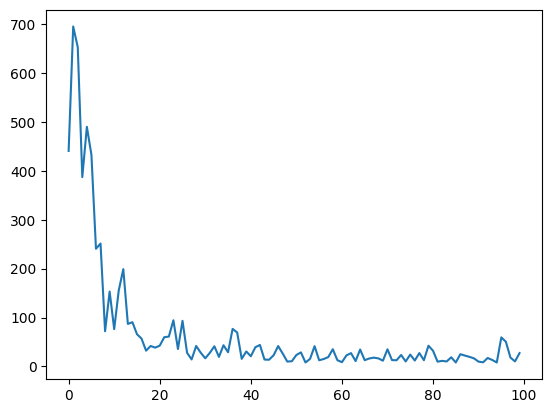

In [ ]:
plt.plot(Loss)

Test set을 이용하여 예측

In [ ]:
# 테스트 데이터(X_test_ts)를 모델에 입력하여 예측 수행 (디바이스에 맞게 변환)
y_pred = model(X_test_ts.to(device)).numpy(force=True)
y_pred.shape

(102, 1)

MSE, R2 계산

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score  # 성능 평가 지표 임포트

# 평균 제곱 오차(MSE) 계산 및 출력
print(mean_squared_error(y_test, y_pred))

# 결정 계수(R² Score) 계산 및 출력
print(r2_score(y_test, y_pred))

32.52160907221527
0.6006111691826317


True vs. Predicted 시각화

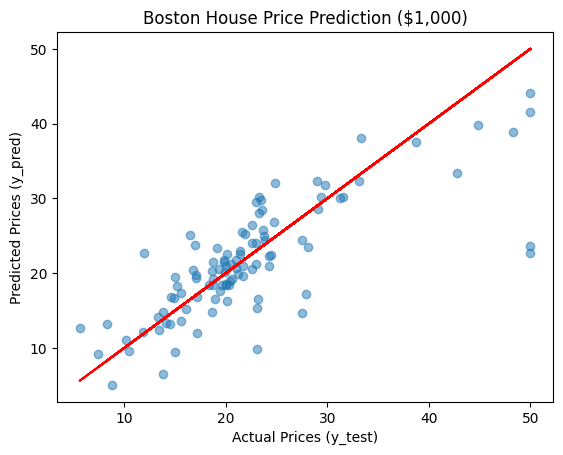

In [ ]:
# 실제값(y_test)과 예측값(y_pred)의 산점도 그리기
plt.scatter(y_test, y_pred, alpha=0.5)  # 투명도(alpha) 조정으로 시각적 가독성 향상

# 완벽한 예측(예측값 = 실제값)을 나타내는 기준선 추가 (빨간색 선)
plt.plot(y_test, y_test, 'r')

# 그래프 레이블 및 제목 설정
plt.xlabel('Actual Prices (y_test)')          # x축: 실제 주택 가격
plt.ylabel('Predicted Prices (y_pred)')    # y축: 예측된 주택 가격
plt.title('Boston House Price Prediction ($1,000)')

plt.show()

### - Boston Dataset 실습을 바탕으로 다른 회귀 문제에도 동일한 MLP 구조를 적용해보세요.


In [3]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing(as_frame=True)
X = california.data
y = california.target
X.shape, y.shape

((20640, 8), (20640,))

In [4]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [7]:
y.head()

,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422
